(quantum-circuit-example)=

# Quantum Circuits

`quimb` has powerful support for simulating quantum circuits via
its ability to represent and contract arbitrary geometry tensor
networks. However, because its representation is generally neither
the full  wavefunction (like many other simulators) or a specific
TN (for example an MPS or PEPS like some other simulators), using
it is a bit different and requires potentially extra thought.

Specifically, the computational  memory and effort is very sensitive
to **what** you want to compute, but also how long you are willing
to spend **computing how to compute it** - essentially, pre-processing.

:::{note}
All of which to say, you are unfortunately quite unlikely to achieve
the best performance without some tweaking of the default arguments.
:::

Nonetheless, here's a quick preview of the kind of circuit that many classical
simulators might struggle with - an 80 qubit GHZ-state prepared using a
completely randomly ordered sequence of CNOTs:

In [1]:
%config InlineBackend.figure_formats = ['svg']

import random
import quimb as qu
import quimb.tensor as qtn

N = 80
circ = qtn.Circuit(N)

# randomly permute the order of qubits
regs = list(range(N))
random.shuffle(regs)

# hamadard on one of the qubits
circ.apply_gate('H', regs[0])

# chain of cnots to generate GHZ-state
for i in range(N - 1):
    circ.apply_gate('CNOT', regs[i], regs[i + 1])

# sample it a few times
for b in circ.sample(1):
    print(b)

00000000000000000000000000000000000000000000000000000000000000000000000000000000


As mentioned above, various pre-processing steps need to occur (which will happen on the first run if not explicitly called). The results of these are cached such that the more you sample the more the simulation should speed up:

In [2]:
%%time
# sample it 8 times
for b in circ.sample(8):
    print(b)

00000000000000000000000000000000000000000000000000000000000000000000000000000000
11111111111111111111111111111111111111111111111111111111111111111111111111111111
00000000000000000000000000000000000000000000000000000000000000000000000000000000
11111111111111111111111111111111111111111111111111111111111111111111111111111111
11111111111111111111111111111111111111111111111111111111111111111111111111111111
00000000000000000000000000000000000000000000000000000000000000000000000000000000
00000000000000000000000000000000000000000000000000000000000000000000000000000000
11111111111111111111111111111111111111111111111111111111111111111111111111111111
CPU times: user 184 ms, sys: 152 µs, total: 184 ms
Wall time: 181 ms


Collect some statistics:

In [3]:
%%time
from collections import Counter

# sample it 100 times, count results:
Counter(circ.sample(100))

CPU times: user 195 ms, sys: 0 ns, total: 195 ms
Wall time: 193 ms


Counter({'11111111111111111111111111111111111111111111111111111111111111111111111111111111': 54,
         '00000000000000000000000000000000000000000000000000000000000000000000000000000000': 46})

## Simulation Steps

Here's an overview of the general steps for a tensor network quantum circuit simulation:

1. Build the **tensor network representation of the circuit**, this involves taking the initial state (by default the product state \$ | 000 \\ldots 00 \\rangle \$ ) and adding tensors representing the gates to it, possibly performing low-rank decompositions on them if beneficial.

2. **Form the entire tensor network of the quantity** you actually want to compute, this might include:

   > - the full, dense, wavefunction (i.e. a single tensor)
   > - a local expectation value or reduced density matrix
   > - a marginal probability distribution to sample bitstrings from, mimicking a real quantum computer (this is what is happening above)
   > - the fidelity with a target state or unitary, maybe to use automatic differentation to train the parameters of a given circuit to perform a specific task

3. Perform **local simplifications on the tensor network** to make it easier (possibly trivial!) to contract. This step, whilst efficient in the complexity sense, can still introduce some significant overhead.

4. Find a **contraction path** for this simplified tensor network. This a series of pairwise tensor contractions that turn the tensor network into a single tensor - represented by a binary *contraction tree*. The memory required for the intermediate tensors can be checked in advance at this stage.

5. Optionally **slice (or 'chunk') the contraction**, breaking it into many independent, smaller contractions, either to fit memory constraints or introduce embarassing parallelism.

6. **Perform the contraction!** Up until this point the tensors are generally very small and so can be easily passed to some other library with which to perform the actual contraction (for example, one with GPU support).

:::{warning}
The overall computational effort memory required in this last step is
**very** sensitive (we are talking possibly *orders and order of magnitude*)
to how well one finds the so-called 'contraction path' or 'contraction tree'
\- which itself can take some effort. The overall simulation is thus a
careful balancing of time spent (a) simplifying (b) path finding, and
(c) contracting.
:::

:::{note}
It's also important to note that this last step is where the exponential slow-down
expected for generic quantum circuits will appear. Unless the circuit is trivial in
some way, the tensor network simplification and path finding can only ever shave
off a (potentially very significant) prefactor from an underlying exponential scaling.
:::

## Building the `Circuit`

The main relevant object is {class}`~quimb.tensor.circuit.Circuit`.
Under the hood this uses {func}`~quimb.tensor.tensor_1d.gate_TN_1D`, which
applies an operator on some number of sites to any notionally 1D tensor network
(not just an MPS), whilst maintaining the outer indices (e.g. `'k0', 'k1', 'k2', ...`).
. The various options for applying the operator
and propagating tags to it (if not contracted in) can be found in
{func}`~quimb.tensor.tensor_1d.gate_TN_1D`. Note that the '1D' nature of the
TN is just for indexing, gates can be  applied to arbitrary combinations of
sites within this 'register'.

The following is a basic example of building a quantum circuit TN by applying
a variety of gates to, for visualization purposes, nearest neighbors in a chain.

In [4]:
# 10 qubits and tag the initial wavefunction tensors
circ = qtn.Circuit(N=10)

# initial layer of hadamards
for i in range(10):
    circ.apply_gate('H', i, gate_round=0)
    
# 8 rounds of entangling gates
for r in range(1, 9):
    
    # even pairs
    for i in range(0, 10, 2):
        circ.apply_gate('CNOT', i, i + 1, gate_round=r)

    # Y-rotations    
    for i in range(10):
        circ.apply_gate('RZ', 1.234, i, gate_round=r)
        
    # odd pairs
    for i in range(1, 9, 2):
        circ.apply_gate('CZ', i, i + 1, gate_round=r)
        
    # X-rotations    
    for i in range(10):
        circ.apply_gate('RX', 1.234, i, gate_round=r)
    
# final layer of hadamards
for i in range(10):
    circ.apply_gate('H', i, gate_round=r + 1)
    
circ

<Circuit(n=10, num_gates=252, gate_opts={'contract': 'auto-split-gate', 'propagate_tags': 'register'})>

The basic tensor network representing the state is stored in the 
``.psi`` attribute, which we can then visualize:

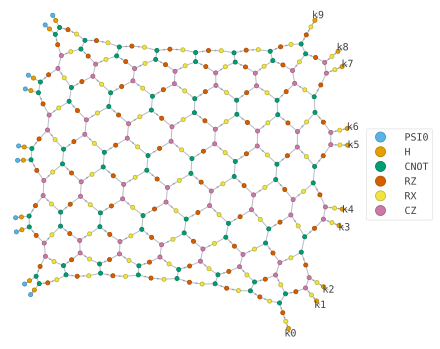

In [5]:
circ.psi.draw(color=['PSI0', 'H', 'CNOT', 'RZ', 'RX', 'CZ'])

Note by default the CNOT and CZ gates have
been split via a rank-2 spatial decomposition into two parts acting on each site seperately
but connected by a new bond. 
We can also graph the default (``propagate_tags='register'``) method for 
adding site tags to the applied operators:

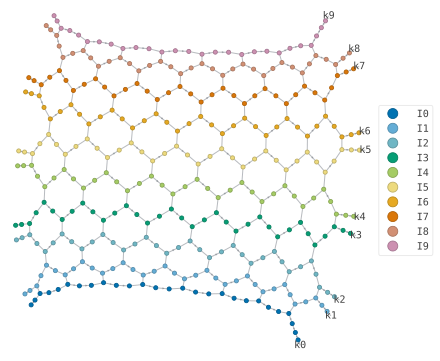

In [6]:
circ.psi.draw(color=[f'I{i}' for i in range(10)])

Or since we supplied ``gate_round`` as an keyword (which is optional), the tensors
are also tagged in that way:

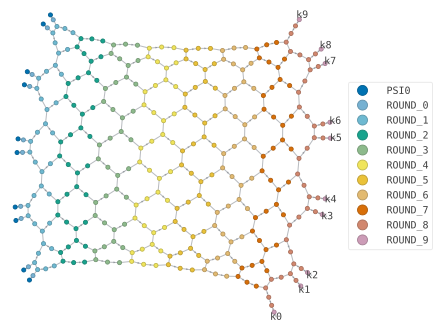

In [7]:
circ.psi.draw(color=['PSI0'] + [f'ROUND_{i}' for i in range(10)])

All of these might be helpful when addressing only certain tensors:

In [8]:
# select the subnetwork of tensors with *all* following tags
circ.psi.select(['CNOT', 'I3', 'ROUND_3'], which='all')

<TensorNetworkGenVector(tensors=1, indices=3)>

:::{note}
The tensor(s) of each gate is/are also individually tagged like
`[f'GATE_{g}' for g in range(circ.num_gates)]`.
:::

The full list of currently implemented gates is here:

In [9]:
sorted(qtn.circuit.ALL_GATES)

['CNOT',
 'CU1',
 'CU2',
 'CU3',
 'CX',
 'CY',
 'CZ',
 'FS',
 'FSIM',
 'FSIMG',
 'H',
 'HZ_1_2',
 'IDEN',
 'IS',
 'ISWAP',
 'RX',
 'RY',
 'RZ',
 'RZZ',
 'S',
 'SU4',
 'SWAP',
 'T',
 'U1',
 'U2',
 'U3',
 'W_1_2',
 'X',
 'X_1_2',
 'Y',
 'Y_1_2',
 'Z',
 'Z_1_2']

## Parametrized Gates

Of these gates, any which take parameters - `['RX', 'RY', 'RZ', 'U3', 'FSIM', 'RZZ', ...]` - can
be 'parametrized', which adds the gate to the network as a
{class}`~quimb.tensor.tensor_core.PTensor`. The main use of this is that when optimizing
a TN, for example, the parameters that generate the tensor data will be optimized rather
than the tensor data itself.

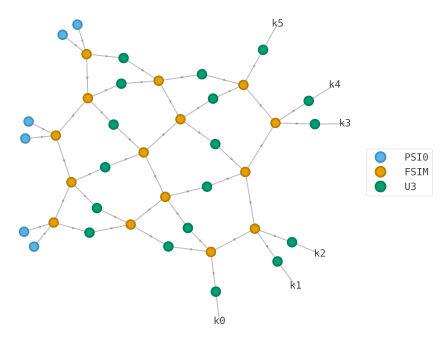

In [10]:
circ_param = qtn.Circuit(6)

for l in range(3):
    for i in range(0, 6, 2):
        circ_param.apply_gate('FSIM', random.random(), random.random(), i, i + 1, parametrize=True, contract=False)
    for i in range(1, 5, 2):
        circ_param.apply_gate('FSIM', random.random(), random.random(), i, i + 1, parametrize=True, contract=False)
    for i in range(6):
        circ_param.apply_gate('U3', random.random(), random.random(), random.random(), i, parametrize=True)
        
circ_param.psi.draw(color=['PSI0', 'FSIM', 'U3'])

We've used the ``contract=False`` option which doesn't try and split the gate tensor in any way,
so here there is now a single tensor per two qubit gate.
In fact, for ``'FSIM'`` and random parameters there is no low-rank decomposition that would happen
anyway, but this is also the only mode compatible with parametrized tensors:

In [11]:
circ_param.psi['GATE_0']

PTensor(shape=(2, 2, 2, 2), inds=('_e81936AAGFn', '_e81936AAGFj', '_e81936AAGFd', '_e81936AAGFe'), tags=oset(['GATE_0', 'FSIM', 'I0', 'I1']))

For most tasks like contraction these are transparently handled like normal tensors:

In [12]:
circ_param.amplitude('101001')

(0.005211487245719964-0.009314484075310034j)

## Forming the Target Tensor Network

You can access the wavefunction tensor network
$U |0\rangle^{\otimes{N}}$
or more generally
$U |\psi_0\rangle$
with `Circuit.psi`
or just the unitary,
$U$,
with `Circuit.uni`, and then manipulate and contract these yourself.
However, there are built-in methods for constructing and contracting
the tensor network to perform various common tasks.

### Compute an amplitude

:::{figure} https://i.imgur.com/3mcnDNp.png
:alt: amplitude
:width: 300
:::

- [Circuit.amplitude](quimb.tensor.circuit.Circuit.amplitude)

This computes a single wavefunction amplitude coefficient, or transition amplitude:

$$
c_x = \langle x | U | \psi_0 \rangle
$$

with, $x=0101010101 \ldots$, for example. The probability of sampling $x$ from this circuit is $|c_x|^2$.

**Example usage:**

In [13]:
circ.amplitude('0101010101')

(-0.006267589645294025+0.012702244544177475j)

### Compute a local expectation

:::{figure} https://i.imgur.com/XuXmTMM.png
:alt: local_expectation
:width: 300
:::

- [`Circuit.local_expectation`](quimb.tensor.circuit.Circuit.local_expectation)

For an operator $G_{\bar{q}}$ acting on qubits $\bar{q}$, this computes:

$$
\langle \psi_{\bar{q}} | G_{\bar{q}} | \psi_{\bar{q}} \rangle
$$

where $\psi_{\bar{q}}$ is the circuit wavefunction but only with gates which are
in the 'reverse lightcone' (i.e. the causal cone) of qubits $\bar{q}$. In the picture
above the gates which we know cancel to the identity have been greyed out (and removed from the
TN used).

**Example usage:**

In [14]:
circ.local_expectation(qu.pauli('Z') & qu.pauli('Z'), (4, 5))

(-0.01818896518545622-1.1709383462843448e-17j)

You can compute several individual expectations on the same sites by supplying a list (they are computed in a single contraction):

In [15]:
circ.local_expectation(
    [qu.pauli('X') & qu.pauli('X'),
     qu.pauli('Y') & qu.pauli('Y'),
     qu.pauli('Z') & qu.pauli('Z')], 
     where=(4, 5),
)

((-0.005784719259097638-2.3689817468808272e-17j),
 (0.05890188167924245+9.540979117872439e-18j),
 (-0.018188965185456298-8.66235070279544e-18j))

### Compute a reduced density matrix

:::{figure} https://i.imgur.com/DAbEdXg.png
:alt: partial_trace
:width: 300
:::

- [`Circuit.partial_trace`](quimb.tensor.circuit.Circuit.partial_trace)

This similarly takes a subset of the qubits, $\bar{q}$, and contracts the
wavefunction with its bra, but now only the qubits outside of $\bar{q}$,
producing a reduced density matrix:

$$
\rho_{\bar{q}} = \mathrm{Tr}_{\bar{p}} | \psi_{\bar{q}} \rangle \langle \psi_{\bar{q}} |
$$

where the partial trace is over $\bar{p}$, the complementary set of qubits to $\bar{q}$.
Obviously once you have $\rho_{\bar{q}}$ you can compute many different local expectations
and so it can be more efficient than repeatedly calling
{meth}`~quimb.tensor.circuit.Circuit.local_expectation`.

**Example usage:**


In [16]:
circ.partial_trace((4, 5)).round(3)

array([[ 0.252+0.j   ,  0.013+0.011j, -0.019+0.007j, -0.016-0.003j],
       [ 0.013-0.011j,  0.255+0.j   ,  0.013+0.014j,  0.02 +0.017j],
       [-0.019-0.007j,  0.013-0.014j,  0.254+0.j   ,  0.019+0.012j],
       [-0.016+0.003j,  0.02 -0.017j,  0.019-0.012j,  0.239+0.j   ]])

### Compute a marginal probability distribution

:::{figure} https://i.imgur.com/stoZ3v8.png
:alt: compute_marginal
:width: 400
:::

- {meth}`~quimb.tensor.circuit.Circuit.compute_marginal`

This method computes the probability distribution over some qubits, $\bar{q}$, conditioned on some
partial fixed result on qubits $\bar{f}$ (which can be no qubits).

$$
p(\bar{q} | x_{\bar{f}}) =
\mathrm{diag}
\mathrm{Tr}_{\bar{p}}
\langle x_{\bar{f}} |
\psi_{\bar{f} \cup \bar{q}} \rangle \langle \psi_{\bar{f} \cup \bar{q}}
| x_{\bar{f}} \rangle
$$

Here only the causal cone relevant to $\bar{f} \cup \bar{q}$ is needed, with the remaining
qubits, $\bar{p}$ being traced out. We directly take the diagonal within the contraction
using hyper-indices (depicted as a COPY-tenso above) to avoid forming the full reduced density matrix.
The result is a $2^{|\bar{q}|}$ dimensional tensor containing the probabilites for each
bit-string $x_{\bar{q}}$, given that we have already 'measured' $x_{\bar{f}}$.

**Example usage:**


In [17]:
p = circ.compute_marginal((1, 2), fix={0: '1', 3: '0', 4: '1'}, dtype='complex128')
p

array([[0.03422455, 0.02085596],
       [0.03080204, 0.02780321]])

In [18]:
qtn.circuit.sample_bitstring_from_prob_ndarray(p / p.sum())

'11'

### Generate unbiased samples

:::{figure} https://i.imgur.com/egpytOg.png
:alt: sample
:width: 800
:::

- [`Circuit.sample`](quimb.tensor.circuit.Circuit.sample)

The main use of [`Circuit.compute_marginal`](quimb.tensor.circuit.Circuit.compute_marginal) is as a subroutine used to generate
unbiased samples from circuits. We first pick some group of qubits, $\bar{q_A}$ to 'measure', then
condition on the resulting bitstring $x_{\bar{q_A}}$, to compute the marginal on the next group of qubits
$\bar{q_B}$ and so forth. Eventually we reach the 'final marginal' where we no longer need to trace
any qubits out, so instead we can compute:

$$
p(\bar{q_Z} | x_{\bar{q_A}} x_{\bar{q_B}} \ldots) =
|\langle x_{\bar{q_A}} x_{\bar{q_B}} \ldots | \psi \rangle|^2
$$

since the 'bra' representing the partial bit-string only acts on some of the qubits this object is still a
$2^{|\bar{q}|}$ dimensional tensor, which we sample from to get the final bit-string $x_{\bar{q_z}}$.
The overall sample generated is then the concatenation of all these bit-strings:

$$
x_{\bar{q_A}} x_{\bar{q_B}} \ldots x_{\bar{q_Z}}
$$

As such, to generate a sample once we have put our qubits into $N_g$ groups, we need to perform $N_g$
contractions. The contractions near the beginning are generally easier since we only need the causal cone for
a small number of qubits, and the contractions towards the end are easier since we have largely or fully severed
the bonds between the ket and bra by conditioning.

This is generally more expensive than computing local quantities but there are a couple of reprieves:

1. **Because of causality we are free to choose the order and groupings of the qubits in whichever way is most efficient.**

The automatic choice is to start at the qubit(s) with the smallest reverse lightcone and greedily expand (see section below).
Grouping the qubits together can have a large beneficial impact on overall computation time, but imposes a hard upper limit
on the required memory like $2^{|\bar{q}|}$.

:::{note}
You can set the group size to be that of the whole sytem, which is equivalent to sampling from the full wavefunction,
if you want to do this, it would be more efficient to call 
[`Circuit.simulate_counts`](quimb.tensor.circuit.Circuit.simulate_counts), which
doesn't draw the samples individually.
:::

2. **Once we have computed a particular marginal we can cache the result, meaning if we come across the same sub-string result,
   we don't need to contract anything again, the trivial example being the first marginal we compute.**

:::{figure} https://i.imgur.com/4jnATD2.png
:alt: branching
:width: 300
:::

The second point is easy to understand if we think of the sampling process as the repeated exploration of a
probability tree as above - which is shown for 3 qubits grouped individually, with a first sample of $011$ drawn.
If the next sample we drew was $010$ we wouldn't have to perform any more contractions, since we'd be following
already explored branches. In the extreme case of the GHZ-state at the top, there are only two branches, so once we
have generated the all-zeros and the all-ones result there we won't need to perform any more contractions.

**Example usage:**

In [19]:
for b in circ.sample(10, group_size=3):
    print(b)

0111100101
0111111010
0111110110
0110111101
1101101010
0101110110
1111000001
0001111111
1111100001
1111011101


### Generate samples from a chaotic circuit

:::{figure} https://i.imgur.com/vIw74uS.png
:alt: sample_chaotic
:width: 310
:::

- [`Circuit.sample_chaotic`](quimb.tensor.circuit.Circuit.sample_chaotic)

Some circuits can be assumed to produce chaotic results, and a useful property of these is that if you remove (partially trace)
a certain number of qubits, the remaining marginal probability distribution is close to uniform.
This is like saying as we travel along the probability tree depicted above, the probabilities are all very similar
until we reach 'the last few qubits', whose marginal distribution then depends sensitively on the bit-string generated
so far.

If we know roughly what number of qubits suffices for this property to hold, $m$, we can uniformly sample bit-strings for the first
$f = N - m$ qubits then we only need to contract the 'final marginal' from above.
In other words, we only need to compute and sample from:

$$
p( \bar{m} | x_{\bar{f}} ) = |\langle x_{\bar{f}} | \psi \rangle|^2
$$

Where $\bar{m}$ is the set of marginal qubits, and $\bar{f}$ is the set of qubits fixed to a random bit-string.
If $m$ is not too large, this is generally a very similar cost to that of computing a single amplitude.

:::{note}
This task is the relevant method for classically simulating the results in ["Quantum supremacy using a programmable
superconducting processor"](https://www.nature.com/articles/s41586-019-1666-5).
:::

**Example usage:**


In [20]:
for b in circ.sample_chaotic(10, marginal_qubits=5):
    print(b)

0000000011
1111010111
1000101011
0110001101
0111111010
1011110110
0001111010
1100110111
0010000001
1101100000


Five of these qubits will now be sampled completely randomly.

### Compute the dense vector representation of the state

:::{figure} https://i.imgur.com/2lak43W.png
:alt: to_dense
:width: 500
:::

- {meth}`~quimb.tensor.circuit.Circuit.to_dense`

In other words just contract the core `circ.psi` object into a single tensor:

$$
U | \psi_0 \rangle \rightarrow |\psi_{\mathrm{dense}}\rangle
$$

Where $|\psi_{\mathrm{dense}}\rangle$ is a column vector.
Unlike other simulators however, the contraction order here isn't defined by the order the gates were applied in,
meaning the full wavefunction does not neccessarily need to be formed until the last few contractions.

:::{hint}
For small to medium circuits, the benefits of doing this as compared with standard, 'Schrodinger-style'
simulation might be negligible (since the overall scaling is still limited by the number of qubits).
Indeed the savings are likely outweighed by the pre-processing step's overhead if you are only running
the circuit geometry once.
:::

**Example usage:**


In [21]:
circ.to_dense()

[[ 0.022278+0.044826j]
 [ 0.047567+0.001852j]
 [-0.028239+0.01407j ]
 ...
 [ 0.016   -0.008447j]
 [-0.025437-0.015225j]
 [-0.033285-0.030653j]]

### Rehearsals

Each of the above methods can perform a trial run, where the tensor networks and contraction paths are generated
and intermediates possibly cached, but the main contraction is not performed. Either supply `rehearse=True` or use
the corresponding partial methods:

- [`Circuit.amplitude_rehearse`](quimb.tensor.circuit.Circuit.amplitude_rehearse)
- [`Circuit.local_expectation_rehearse`](quimb.tensor.circuit.Circuit.local_expectation_rehearse)
- [`Circuit.partial_trace_rehearse`](quimb.tensor.circuit.Circuit.partial_trace_rehearse)
- [`Circuit.compute_marginal_rehearse`](quimb.tensor.circuit.Circuit.compute_marginal_rehearse)
- [`Circuit.sample_rehearse`](quimb.tensor.circuit.Circuit.sample_rehearse)
- [`Circuit.sample_chaotic_rehearse`](quimb.tensor.circuit.Circuit.sample_chaotic_rehearse)
- [`Circuit.to_dense_rehearse`](quimb.tensor.circuit.Circuit.to_dense_rehearse)

These each return a `dict` with the tensor network that *would* be
contracted in the main part of the computation (with the key `'tn'`),
and the {class}`opt_einsum.PathInfo` object describing the contraction
path found for that tensor network (with the key `'info'`). For example:


In [22]:
rehs = circ.amplitude_rehearse()

# contraction width
W = qu.log2(rehs['info'].largest_intermediate)
W

8.0

Upper twenties is the limit for standard (~10GB) amounts of RAM.

In [23]:
# contraction cost
# N.B.  raw .opt_cost assumes *real* dtype FLOPs
#       * 4  to get complex dtype FLOPs (relevant for most QC)
#       / 2  to get dtype independent scalar OPs (the 'cost')
C = qu.log10(rehs['info'].opt_cost / 2)  
C

3.993171605030765

In [24]:
# perform contraction
rehs['tn'].contract(all, optimize=rehs['info'].path, output_inds=())

(-0.051114783327090685+0.021377400001729312j)

{meth}`~quimb.tensor.circuit.Circuit.sample_rehearse`
and
{meth}`~quimb.tensor.circuit.Circuit.sample_chaotic_rehearse`
both return a dict of dicts, where the keys of the top dict
are the (ordered) groups of marginal qubits used, and the values
are the rehearsal dicts as above.

In [25]:
rehs = circ.sample_rehearse(group_size=3)
rehs.keys()

dict_keys([(0, 1, 2), (3, 4, 9), (5, 6, 7), (8,)])

In [26]:
rehs[(3, 4, 9)].keys()

dict_keys(['tn', 'info', 'W', 'C'])

### Unitary Reverse Lightcone Cancellation

In several of the examples above we made use of 'reverse lightcone', or the set of gates
that have a causal effect on a particular set of output qubits, $\bar{q}$, to work
with a potentially much smaller TN representation of the wavefunction:

$$
| \psi_{\bar{q}} \rangle
$$

This can simply be understood as cancellation of the gate unitaries at the boundary where
the bra and ket meet:

$$
U^{\dagger} U = \mathcal{1}
$$

if there are no operators or projectors breaking this bond between the bra and ket.
Whilst such simplifications can be found by the local simplifications (see below) its
easier and quicker to drop these explicitly.

You can see which gate tags are in the reverse lightcone of which regions of qubits by calling:


In [27]:
# just show the first 10...
lc_tags = circ.get_reverse_lightcone_tags(where=(0,))
lc_tags[:10]

('PSI0',
 'GATE_0',
 'GATE_1',
 'GATE_2',
 'GATE_3',
 'GATE_4',
 'GATE_5',
 'GATE_6',
 'GATE_7',
 'GATE_8')

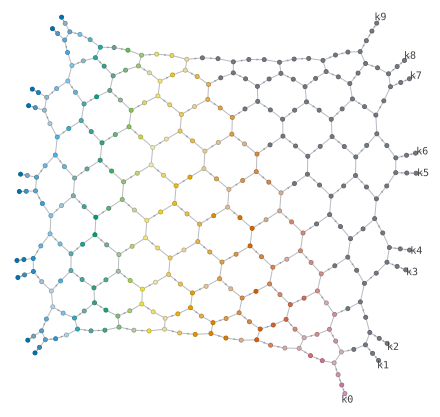

In [28]:
circ.psi.draw(color=lc_tags, legend=False)

We can plot the effect this has as selecting only these, $| \psi \rangle \rightarrow | \psi_{\bar{q}} \rangle$, on the norm with the following:

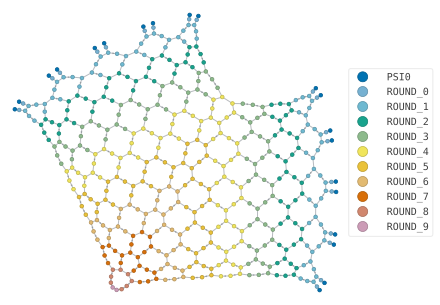

In [29]:
# get the reverse lightcone wavefunction of qubit 0
psi_q0 = circ.get_psi_reverse_lightcone(where=(0,))

# plot its norm
(psi_q0.H & psi_q0).draw(color=['PSI0'] + [f'ROUND_{i}' for i in range(10)])

:::{note}
Although we have specified gate rounds here, this is not required to find the reverse
lightcones, and indeed arbitrary geometry is handled too.
:::

## Locally Simplifying the Tensor Network (the `simplify_sequence` kwarg)

All of the main circuit methods take a `simplify_sequence` kwarg that controls local
tensor network simplifications that are performed on the target TN object before
the main contraction. The kwarg is a string of letters which is cycled through
til convergence, which each letter corresponding to a different method:

- `'A'`: [`TensorNetwork.antidiag_gauge`](quimb.tensor.tensor_core.TensorNetwork.antidiag_gauge)
- `'D'`: [`TensorNetwork.diagonal_reduce`](quimb.tensor.tensor_core.TensorNetwork.diagonal_reduce)
- `'C'`: [`TensorNetwork.column_reduce`](quimb.tensor.tensor_core.TensorNetwork.column_reduce)
- `'R'`: [`TensorNetwork.rank_simplify`](quimb.tensor.tensor_core.TensorNetwork.rank_simplify)
- `'S'`: [`TensorNetwork.split_simplify`](quimb.tensor.tensor_core.TensorNetwork.split_simplify)

The final object thus both depends on which letters and the order specified
-- `'ADCRS'` is the default.

As an example, here is the `amplitude` tensor network of the circuit above,
with only 'rank simplification' (contracting neighboring tensors that won't increase
rank) performed:

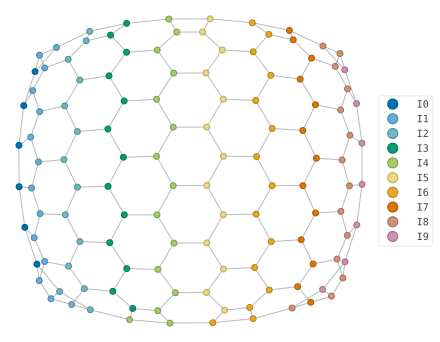

In [30]:
(
    circ
    # get the tensor network
    .amplitude_rehearse(simplify_sequence='R')['tn']
    # plot it with each qubit register highlighted
    .draw(color=[f'I{q}' for q in range(10)])
)

You can see that only 3+ dimensional tensors remain. Now if we turn on all the 
simplification methods we get an even smaller tensor network:

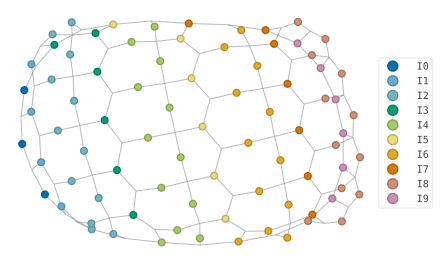

In [31]:
(
    circ
    # get the tensor network
    .amplitude_rehearse(simplify_sequence='ADCRS')['tn']
    # plot it with each qubit register highlighted
    .draw(color=[f'I{q}' for q in range(10)])
)

And we also now have *hyper-indices* - indices shared by more than two tensors - that have been
introduced by the [`TensorNetwork.diagonal_reduce`](quimb.tensor.tensor_core.TensorNetwork.diagonal_reduce) method.

:::{hint}
Of the five methods, only [`TensorNetwork.rank_simplify`](quimb.tensor.tensor_core.TensorNetwork.rank_simplify) doesn't
require looking inside the tensors at the sparsity structure. This means that, at least for the moment,
it is the only method that can be back-propagated through, for example.
:::

The five methods combined can have a significant effect on the complexity of the main TN to be contracted,
in the most extreme case they can reduce a TN to a scalar:

In [32]:
norm = circ.psi.H & circ.psi
norm

<TensorNetworkGen(tensors=668, indices=802)>

In [33]:
norm.full_simplify_(seq='ADCRS')

<TensorNetworkGen(tensors=87, indices=67)>

Here, [`TensorNetwork.full_simplify`](quimb.tensor.tensor_core.TensorNetwork.full_simplify), (which is the method that cycles through
the other five) has reduced the 500 tensors to a single scalar via local simplifications only. Clearly we
know the answer should be 1 anyway, but its nice to confirm it can indeed be found automatically as well:

In [34]:
# we specify output_inds since we now have a hyper tensor network
norm.contract(..., output_inds=())

(0.9999999999999587-9.159339953157541e-16j)

## Finding a Contraction Path (the `optimize` kwarg)

As mentioned previously, the main computational bottleneck (i.e. as we scale up circuits, the step that always
becomes most expensive) is the actual *contraction* of the main tensor network objects, post simplification.
The cost of this step (which is recorded in the rehearsal's `'info'` objects) can be **incredibly sensitive**
to the *contraction path* - the series of pairwise merges that define how to turn the collection of tensors into
a single tensor.

You control this aspect of the quantum circuit simulation via the `optimize` kwarg, which can take a number
different types of values:

> 1. A string, specifiying an [opt_einsum](https://optimized-einsum.readthedocs.io/) registered path optimizer.
> 2. A custom `opt_einsum.PathOptimizer` instance, like those found in [cotengra](https://github.com/jcmgray/cotengra).
> 3. An explicit path - a sequence of pairs of ints - likely found from a previous rehearsal, for example.

:::{note}
The default value is `'auto-hq'` which is the highest quality preset `opt_einsum` has, but this is
**pretty unlikely to offer the best performance for large or complex circuits**.
:::

As an example we'll show how to use each type of `optimize` kwarg for computing the local expecation:

$$
\langle \psi_{3, 4} | Z_3 \otimes Z_4 | \psi_{3, 4} \rangle
$$


In [35]:
# compute the ZZ correlation on qubits 3 & 4
ZZ = qu.pauli('Z') & qu.pauli('Z')
where = (3, 4)

### An `opt_einsum` preset

First we use the fast but low quality `'greedy'` preset:

In [36]:
rehs = circ.local_expectation_rehearse(ZZ, where, optimize='greedy')
tn, info = rehs['tn'], rehs['info']
info.opt_cost

Decimal('264240')

Because we used a preset, the path is cached by `quimb`, meaning the
path optimization won't run again for the same geometry.

:::{hint}
You can set a persistent disk cache  for `quimb` to use with
{func}`~quimb.tensor.tensor_core.set_contract_path_cache`.
:::

Now we can run the actual computation, reusing that path automatically:

In [37]:
%%timeit
circ.local_expectation(ZZ, where, optimize='greedy')

28.4 ms ± 744 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can compare this to just performing the main contraction:

In [38]:
%%timeit
tn.contract(all, optimize=info.path, output_inds=())

3.54 ms ± 79.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Where we see that most of the time is evidently spent preparing the TN.

### An `opt_einsum.PathOptimizer` instance

You can also supply a customized `PathOptimizer` instance here, an example of which
is the `opt_einsum.RandomGreedy`
[optimizer](https://optimized-einsum.readthedocs.io/en/stable/random_greedy_path.html)
(which is itself called by `'auto-hq'` in fact).


In [39]:
import opt_einsum as oe

# up the number of repeats and make it run in parallel
opt_rg = oe.RandomGreedy(max_repeats=256, parallel=True)

rehs = circ.local_expectation_rehearse(ZZ, where, optimize=opt_rg)
tn, info = rehs['tn'], rehs['info']
info.opt_cost

Decimal('186984')

We see it has found a much better path than `'greedy'`, which is not so surprising.

Unlike before, if we want to reuse the path found from this, we can directly access the `.path`
attribute from the `info` object (or the `PathOptimizer` object):

In [41]:
%%timeit
circ.local_expectation(ZZ, where, optimize=info.path)

26.3 ms ± 426 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We've shaved some time off but not much because the computation is not dominated by the
contraction at this scale.

:::{note}
If you supplied the `opt_rg` optimizer again, it would run for an additional
256 repeats, before returning its best path -- this can be useful if you want
to incrementally optimize the path, check its cost and then optimize more,
before switching to `.path` when you actually want to contract, for example.
:::

### A custom `opt_einsum.PathOptimizer` instance

`opt_einsum` [defines an interface for custom path optimizers](https://optimized-einsum.readthedocs.io/en/stable/custom_paths.html),
which other libraries, or any user, can subclass and then supply as the
`optimize` kwarg and will thus be compatible with `quimb`.
The `cotengra` [library](https://github.com/jcmgray/cotengra) offers
'hyper'-optimized contraction paths that are aimed at (and strongly recommended for)
large and complex tensor networks. It provides:

- The `optimize='hyper'` preset (once `cotengra` is imported)
- The `cotengra.HyperOptimizer` single-shot path optimizer, (like `RandomGreedy` above)
- The `cotengra.ReusableHyperOptimizer`, which can be used for many contractions, and caches the results (optionally to disk)

The last is probably the most practical so we'll demonstrate it here:

In [45]:
import cotengra as ctg

# the kwargs ReusableHyperOptimizer take are the same as HyperOptimizer
opt = ctg.ReusableHyperOptimizer(
    max_repeats=16, 
    reconf_opts={},
    parallel=False,
    progbar=True,
#     directory=True,  # if you want a persistent path cache
)

rehs = circ.local_expectation_rehearse(ZZ, where, optimize=opt)
tn, info = rehs['tn'], rehs['info']
info.opt_cost

log2[SIZE]: 10.00 log10[FLOPs]: 4.95: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Decimal('89440')

We can see even for this small contraction it has improved on the `RandomGreedy` path cost.
We could use `info.path` here but since we have a `ReusableHyperOptimizer` path
optimizer, this second time its called on the same contraction it will simply get
the path from its cache anway:

In [46]:
%%timeit
circ.local_expectation(ZZ, where, optimize=opt)

26.5 ms ± 434 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Again, since the main contraction is very small, we don't see any real improvement.

`cotengra` also has a `ContractionTree` object for manipulating and visualizing
the contraction paths found.

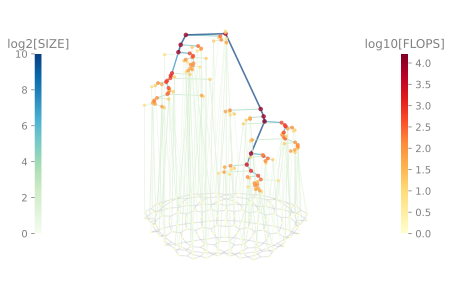

In [47]:
tree = ctg.ContractionTree.from_info(info)
tree.plot_tent(order=True)

Here the, grey network at the bottom is the TN to be contracted, and the tree
above it depicts the series of pairwise contractions and their individual cost
needed to find the output answer (the node at the top).

## Performing the Contraction (the `backend` kwarg)

`quimb` and `opt_einsum` both try and be agnostic to the actual arrays they manipulate / contract.
Currently however, the tensor network `Circuit` constructs and simplifies is made up of `numpy.ndarray` backed tensors since they are all generally very small:

In [48]:
{t.size for t in tn}

{2, 4, 8}

When it comes to the actual contraction however, where large tensors will appear, it can be advantageous to
use a different library to perform the contractions. If you specify a ``backend`` kwarg, before contraction,
the arrays will converted to the ``backend``, then the contraction performed, and the result converted back
to ``numpy``. 
[The list of available backends is here](https://optimized-einsum.readthedocs.io/en/stable/backends.html#special-gpu-backends-for-numpy-arrays), including:


* `cupy`
* `jax` (note this actively defaults to single precision)
* `torch`
* `tensorflow`

Sampling is an excellent candidate for GPU acceleration as the same geometry TNs
are contracted over and over again and since sampling is inherently a low 
precision task, single precision arrays are a natural fit.

In [49]:
for b in circ.sample(10, backend='jax', dtype='complex64'):
    print(b)

0010111011
1001010001
1001000011
0001110010
1111011010
0010001000
0100010101
0111101001
0111100001
1010010010


:::{note}
Both sampling methods,
[`Circuit.sample`](quimb.tensor.circuit.Circuit.sample) and
[`Circuit.sample_chaotic`](quimb.tensor.circuit.Circuit.sample_chaotic),
default to `dtype='complex64'`. The other methods default
to `dtype='complex128'`.
:::

## Performance Checklist

Here's a list of things to check if you want to ensure you are getting the
most performance out of your circuit simulation:

- What contraction path optimizer are you using? If performance isn't great, have you tried `cotengra`?
- How are you applying the gates? For example, `gate_opts={'contract': False}` (no decomposition) can be better for diagonal 2-qubit gates.
- How are you grouping the qubits? For sampling, there is a sweet spot for `group_size` usually. For chaotic sampling, you might try the *last* \$M\$ marginal qubits rather than the *first*, for example.
- What local simplifications are you using, and in what order? `simplify_sequence='SADCR'` is also good sometimes.
- If the computation is contraction dominated, can you run it on a GPU?
